## unificar datos de absorbancia

juntamos todos los archivos `.csv` que contienen datos de absorbancia de distintas muestras de café (7.5g, 15g, 18g y 22.5g)

Cada archivo trae una columna con valores de absorbancia y otra con las longitudes de onda. Lo que hacemos es:

- Ordenarlos por gramaje
- Limpiar datos a nan (not a number)
- Ponerle nombre a cada columna según el archivo (i.e: AVeMN7_5g, AVeMN15g, AVeMN18g y AVeMN22_5g)
- Y al final, unir todo en una sola tabla (matriz), en donde:
  - Las filas son las longitudes de onda
  - Las columnas son las muestras

Con eso ya tenemos una **matriz de datos lista para graficar o analizar.**


In [1]:
import pandas as pd
import os
import re

# Detectamos los archivos CSV válidos
archivos_csv = [f for f in os.listdir() if f.endswith('.csv') and f != 'AVeMN.csv']

# Extraemos los gramajes de los nombres para ordenar correctamente
def extraer_gramos(nombre):
    match = re.search(r'(\d+_?\d*)g', nombre)
    if match:
        return float(match.group(1).replace('_', '.'))
    return float('inf')  # Para evitar errores si no hay match

# Ordenamos los archivos por gramaje
archivos_ordenados = sorted(archivos_csv, key=extraer_gramos)

# Se leen los archivos y se preparan los DataFrames
dataframes = []
for archivo in archivos_ordenados:
    df = pd.read_csv(archivo)

    # Eliminamos filas que no tienen número válido en la primera columna (longitud de onda)
    df = df[pd.to_numeric(df.iloc[:, 0], errors='coerce').notna()]

    # Renombramos las columnas para unificarlas
    nombre_columna = os.path.splitext(archivo)[0]
    df.columns = ['nm', nombre_columna]
    df[nombre_columna] = pd.to_numeric(df[nombre_columna], errors='coerce')  # convertir a número
    dataframes.append(df)

# Unimos todos los DataFrames por la columna 'nm'
df_consolidado = dataframes[0]
for df in dataframes[1:]:
    df_consolidado = pd.merge(df_consolidado, df, on='nm', how='outer')

# Guardamos el archivo final
df_consolidado.to_csv('AVeMN_matrix.csv', index=False)

print("Archivo 'AVeMN_matrix.csv' creado")




Archivo 'AVeMN_matrix.csv' creado


## verificamos la matriz de datos

Una vez que ya unimos todos los datos en el archivo `AVeMN.csv`, ahora toca revisarlos para entender su forma.

Usamos dos funciones de la librería `pandas`: 

- `head()` para ver las primeras filas y verificar que las columnas se hayan unido bien
- `info()` para saber cuántos datos tiene cada muestra y cuántos valores faltantes hay (`NaN`)



In [2]:
import pandas as pd

In [3]:
datos = pd.read_csv("AVeMN_matrix.csv")

In [4]:
datos.head()

,nm,AVeMN7_5g,AVeMN15g,AVeMN18g,AVeMN22_5g
0,190.0,NaN,NaN,NaN,NaN
1,190.5,NaN,NaN,NaN,NaN
2,191.0,NaN,NaN,NaN,NaN
3,191.5,NaN,NaN,NaN,NaN
4,192.0,NaN,1.699,NaN,NaN


Vemos que:


- Donde no hay medición, aparece un `NaN`


In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nm          821 non-null    float64
 1   AVeMN7_5g   414 non-null    float64
 2   AVeMN15g    813 non-null    float64
 3   AVeMN18g    338 non-null    float64
 4   AVeMN22_5g  364 non-null    float64
dtypes: float64(5)
memory usage: 32.2 KB


- Hay **821 longitudes de onda (filas)**.
- Algunas muestras tienen más datos que otras (por ejemplo, AVeMN7_5g tiene 414 valores válidos, mientras que AVeMN18g tiene 338).

## Graficamos las curvas de absorbancia ordenadas por intensidad

Ya con la matriz de datos limpia (valores NaN donde hubo saturación), graficamos las curvas de absorbancia de las muestras de café (7.5g, 15g, 18g y 22.5g).

Pasos:
- Limpiamos valores fuera de rango (absorbancias > 10)
- Calculamos el valor máximo de absorbancia para cada muestra
- Reordenamos las columnas según ese valor
- Y finalmente, graficamos todas las curvas con `matplotlib`




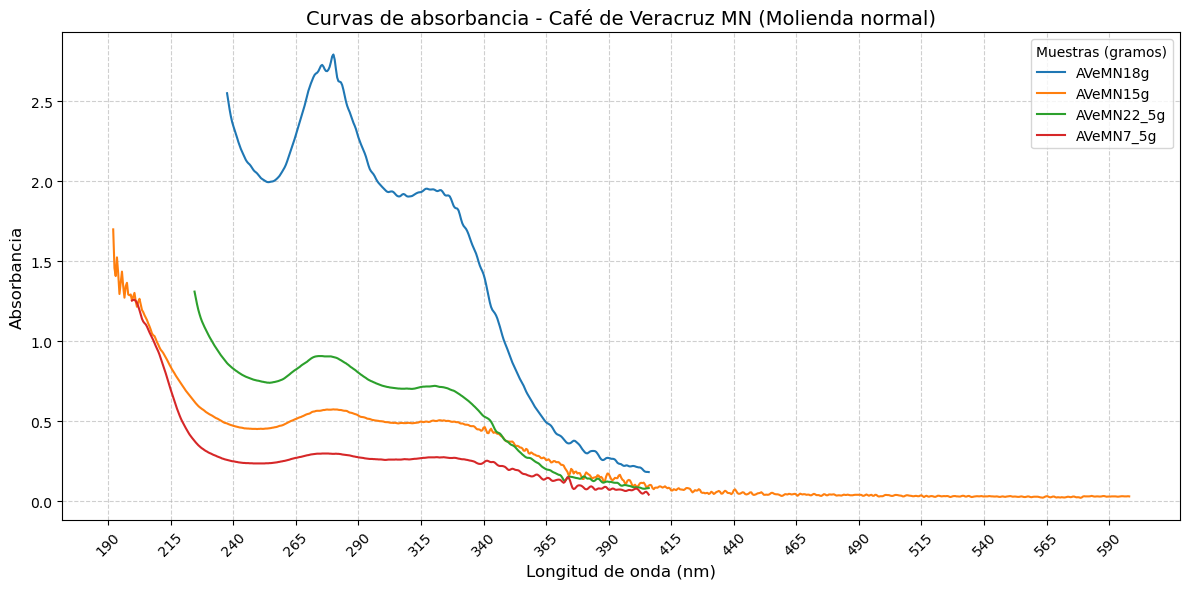

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargamos el archivo con las mediciones de absorbancia unidas en una matriz de datos
df = pd.read_csv("AVeMN_matrix.csv")

# Limpiamos datos fuera de rango (>10)
for columna in df.columns[1:]:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')
    df.loc[df[columna] > 10, columna] = None

# Obtenemos los valores máximos de cada curva
maximos = {
    columna: df[columna].max(skipna=True)
    for columna in df.columns[1:]
}

# Ordenamos de mayor a menor para que la leyenda coincida con las curvas
columnas_ordenadas = sorted(maximos, key=maximos.get, reverse=True)

# Creamos figura
plt.figure(figsize=(12, 6))

# Dibujamos las curvas ya ordenadas
for columna in columnas_ordenadas:
    plt.plot(df['nm'], df[columna], label=columna)

# Etiquetas y estilo
plt.xlabel('Longitud de onda (nm)', fontsize=12)
plt.ylabel('Absorbancia', fontsize=12)
plt.title('Curvas de absorbancia - Café de Veracruz MN (Molienda normal)', fontsize=14)
plt.legend(title='Muestras (gramos)', fontsize=10)
plt.xticks(df['nm'][::50], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




## Graficamos las curvas suavizadas y ordenadas por intensidad

A partir de la matriz de datos y limpia (NaN), ahora generamos una gráfica más estética y legible aplicando suavizado:

- Usamos `savgol_filter` (filtro de savitzky-golay) para suavizar las curvas
- Calculamos el valor máximo de cada curva suavizada
- Reordenamos las muestras de mayor a menor según ese pico
- Finalmente, graficamos con `seaborn` y `matplotlib`, usando una paleta amigable y una cuadrícula para facilitar la lectura




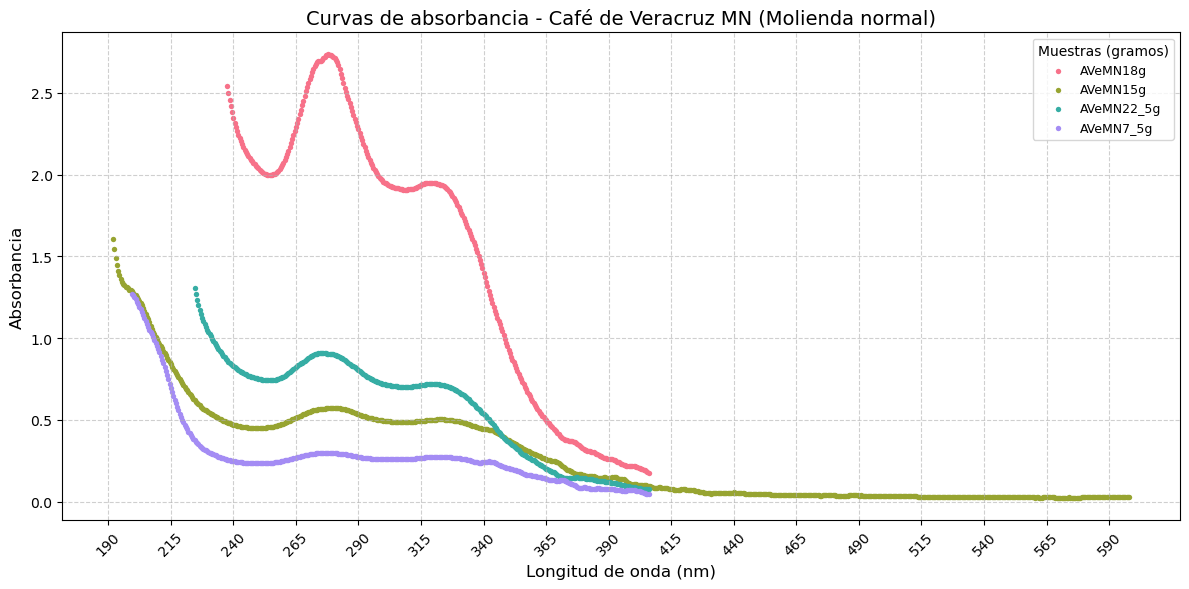

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sb
import numpy as np

# Cargamos la matriz de datos con las mediciones de absorbancia unidas 
df = pd.read_csv("AVeMN_matrix.csv")

# Convertimos valores y descartamos saturación
for columna in df.columns[1:]:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')
    df.loc[df[columna] > 10, columna] = None

# Obtenemos máximos de las curvas suavizadas
max_absorbancias = {}

for columna in df.columns[1:]:
    datos_validos = df[columna].dropna()
    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos, window_length=21, polyorder=3)
        max_absorbancias[columna] = np.max(y_suave)
    else:
        max_absorbancias[columna] = -np.inf  # Muy bajo para que quede al final

# Ordenamos columnas por su valor máximo suavizado
columnas_ordenadas = sorted(max_absorbancias, key=max_absorbancias.get, reverse=True)

# Paleta de color amigable
colores = sb.color_palette("husl", len(columnas_ordenadas))

# Figura
plt.figure(figsize=(12, 6))

# Graficamos suavizado por muestra, en orden 
for i, columna in enumerate(columnas_ordenadas):
    datos_validos = df[columna].dropna()
    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos, window_length=21, polyorder=3)
        x_vals = df['nm'][datos_validos.index]
        sb.scatterplot(x=x_vals, y=y_suave, s=15, label=columna, color=colores[i], linewidth=0)
    else:
        plt.plot(df['nm'], df[columna], label=columna, color=colores[i], linestyle='--')

# Estética
plt.xlabel('Longitud de onda (nm)', fontsize=12)
plt.ylabel('Absorbancia', fontsize=12)
plt.title('Curvas de absorbancia - Café de Veracruz MN (Molienda normal)', fontsize=14)
plt.legend(title='Muestras (gramos)', fontsize=9)
plt.xticks(df['nm'][::50], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




## Suavizado con curvas con gradiente

Usamos ahora en este caso un gradiente de color que refleja la intensidad

- Quitamos valores saturados (>10)
- Suavizamos las curvas (si hay datos suficientes)
- Ordenamos por intensidad máxima
- Dibujamos: si la curva está completa, va con gradiente; si no, con línea punteada



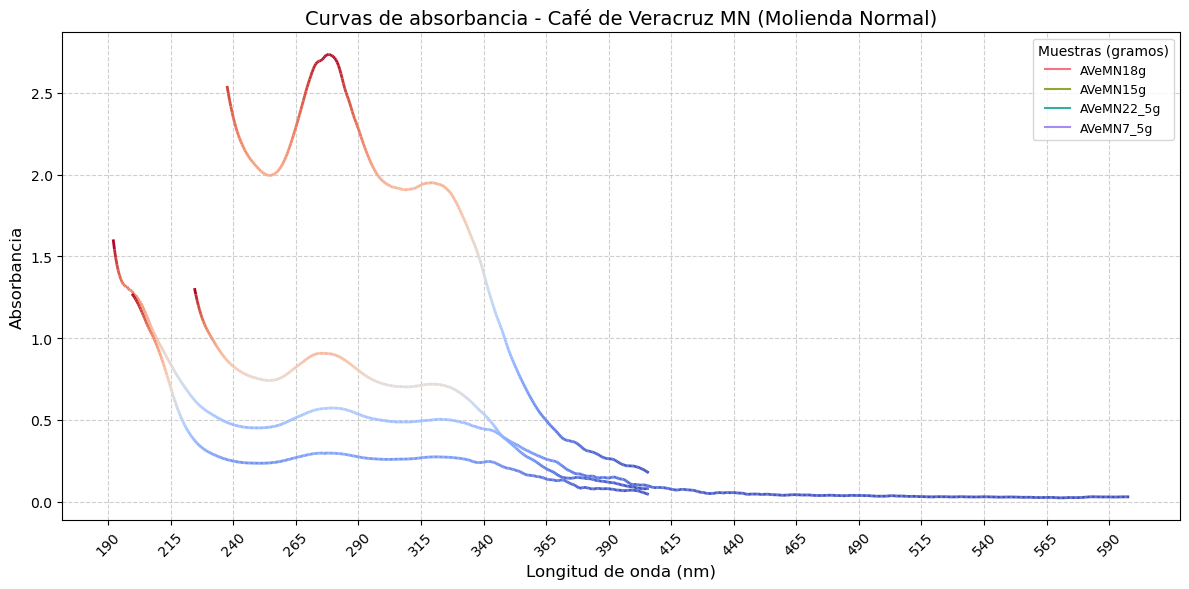

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import seaborn as sb
import numpy as np

# Cargamos la matriz de datos con las mediciones de absorbancia unidas 
df = pd.read_csv("AVeMN_matrix.csv")

# Procesamos columnas de absorbancia (excepto 'nm')
for columna in df.columns[1:]:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')
    df.loc[df[columna] > 10, columna] = None

# Diccionario para guardar valores máximos de cada curva suavizada
max_absorbancias = {}

# Calculamos máximos de cada columna suavizable
for columna in df.columns[1:]:
    datos_validos = df[columna].dropna()
    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos, window_length=21, polyorder=3)
        max_absorbancias[columna] = np.max(y_suave)
    else:
        max_absorbancias[columna] = np.nan  # O podemos usar max original

# Ordenamos columnas por valor máximo descendente
columnas_ordenadas = sorted(max_absorbancias, key=max_absorbancias.get, reverse=True)

# Figura principal
plt.figure(figsize=(12, 6))
plt.title("Curvas de absorbancia - Café de Veracruz MN (Molienda Normal)", fontsize=14)

# Paleta para los colores
colores_base = sb.color_palette("husl", len(columnas_ordenadas))

# Plot
for i, columna in enumerate(columnas_ordenadas):
    datos_validos = df[['nm', columna]].dropna()

    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos[columna], window_length=21, polyorder=3)
        x = datos_validos['nm'].values
        y = y_suave

        puntos = np.array([x, y]).T.reshape(-1, 1, 2)
        segmentos = np.concatenate([puntos[:-1], puntos[1:]], axis=1)

        norm = mcolors.Normalize(vmin=np.min(y), vmax=np.max(y))
        lc = LineCollection(segmentos, cmap='coolwarm', norm=norm)
        lc.set_array(y)
        lc.set_linewidth(2.0)
        plt.gca().add_collection(lc)

        plt.plot([], [], color=colores_base[i], label=columna)
    else:
        plt.plot(df['nm'], df[columna], linestyle='--', color=colores_base[i], label=columna)

# Ejes y estética
plt.xlabel("Longitud de onda (nm)", fontsize=12)
plt.ylabel("Absorbancia", fontsize=12)
plt.legend(title="Muestras (gramos)", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(df['nm'][::50], rotation=45)
plt.tight_layout()
plt.show()
